In [1]:
# 导入相应的库
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import datetime

In [2]:
# 定义超参数
# 训练批次大小
train_batch_size = 100
# 测试批次大小
test_batch_size = 100
# 学习率
learning_rate = 0.01
# 迭代次数
num_epoches = 10

#动量
momentum = 0

#丢弃率
dropout_rate = 0.5
#判断是否有GPU，如果有则使用GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

#标签顺序
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



In [3]:
# 定义预处理函数
transform = transforms.Compose([
    #将图像数据转换为张量
    transforms.ToTensor(), 
    #将图像数据归一化到[-1,1]
    #transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    # #随机水平翻转
    # transforms.RandomHorizontalFlip(),
    # #随机遮挡
    # transforms.RandomErasing(scale=(0.04,0.2), ratio=(0.5,2)),
    # #随机裁剪
    # transforms.RandomCrop(32, padding=4)
])  

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
#下载数据，并对数据进行预处理
mnist_train= torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform,download=True) 
mnist_test= torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test,download=True)
mnist_show= torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(),download=False)
#得到一个生成器
train_loader = DataLoader(mnist_train, batch_size=train_batch_size)
test_loader = DataLoader(mnist_test, batch_size=test_batch_size)
show_loader = DataLoader(mnist_show, batch_size=test_batch_size)

Files already downloaded and verified
Files already downloaded and verified


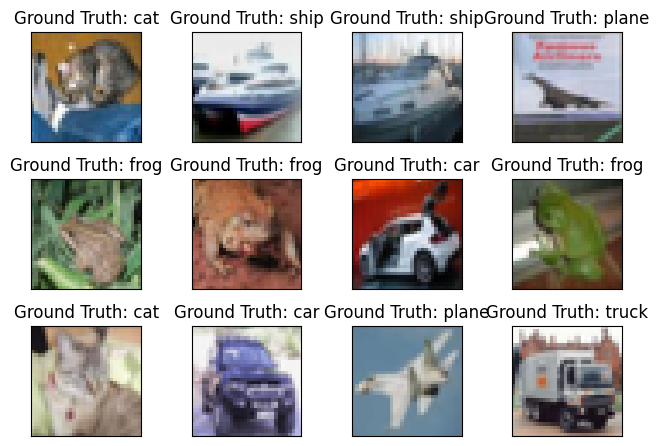

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7])
torch.Size([100])


In [4]:
# 可视化源数据
# 打印测试集数据标签
examples = enumerate(show_loader) #用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标

batch_idx, (imgs, labels) = next(examples) #读取数据,batch_idx从0开始
#绘制部分数据图像
fig = plt.figure() #创建一个图像
for i in range(12):
    plt.subplot(3,4,i+1) #3行4列，第i+1个子图
    plt.tight_layout() #自动调整子图参数,使之填充整个图像区域
    plt.imshow(imgs[i].permute(1,2,0), interpolation='none') #绘制图像
    plt.title("Ground Truth: {}".format(classes[labels[i].item()])) #设置标题
    plt.xticks([]) #设置x轴刻度为空
    plt.yticks([]) #设置y轴刻度为空
plt.show() #显示图像
print(labels) #读取标签数据
print(labels.shape) #torch.Size([32])，因为batch_size为32

In [5]:
# 构建模型
class Net(nn.Module):
    # """
    # 使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    # """
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            #lenet-5
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*4*4, 64),
            # 激活函数
            nn.ReLU(True),
            #新增的隐藏层
            # nn.Linear(256, 64),
            # 激活函数
            # nn.ReLU(True),
            nn.Linear(64, 10),
            nn.ReLU(True),
        )
    def forward(self, x):
        x = self.model(x)
        return x
    
#创建模型实例
model = Net().to(device)
# 损失函数
criterion = nn.CrossEntropyLoss().to(device)
# 优化器
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# 其他几种优化算法：
# opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
# opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
# opt_RMSProp = torch.optim.RMSprop(net_RMSProp.parameters(), lr=LR, alpha=0.9)
# opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))




In [ ]:
# 训练模型并绘制Loss函数曲线
print('start training')
iterations = 0
#记录数据
losses = []
acces = []
eval_losses = []
eval_acces = []

#开始计时
start = datetime.datetime.now()

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    #动态修改学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.9
        print('lr is set to {}'.format(optimizer.param_groups[0]['lr']))
    for img,label in train_loader:
        img,label = img.to(device),label.to(device)
        #前向传播
        out = model(img)
        #计算损失
        loss = criterion(out,label)
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #记录误差
        train_loss += loss.item()
        #计算准确率
        _,pred = torch.max(out,1)
        num_correct = (pred == label).sum().item()
        acc = num_correct/img.shape[0]
        train_acc += acc
    losses.append(train_loss/len(train_loader))
    acces.append(train_acc/len(train_loader))
    #在测试集上测试
    eval_loss = 0
    eval_acc = 0

    model.eval()
    for img,label in test_loader:
        img,label = img.to(device),label.to(device)
        out = model(img)
        loss = criterion(out,label)
        #记录误差
        eval_loss += loss.item()
        #计算准确率
        _,pred = torch.max(out,1)
        num_correct = (pred == label).sum().item()
        acc = num_correct/img.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss/len(test_loader))
    eval_acces.append(eval_acc/len(test_loader))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Test Loss: {:.6f}, Test Acc: {:.6f}'
          .format(epoch, train_loss/len(train_loader), train_acc/len(train_loader), 
                  eval_loss/len(test_loader), eval_acc/len(test_loader)))
#结束计时
end = datetime.datetime.now()
# 绘制损失函数曲线
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses, "blue", label="Training Loss")
plt.plot(np.arange(len(eval_losses)), eval_losses, "red", label="Test Loss")
plt.xlim([0,epoch])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.savefig('./loss_basic.png')
# 计算训练时间
print('time used: ', end-start)
torch.save(model,'./model/model_basic.ckpt')


start testing


C:\Users\Darwin_\AppData\Local\Temp\ipykernel_17456\3266975109.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test = torch.load('./model/model_basic.ckpt')


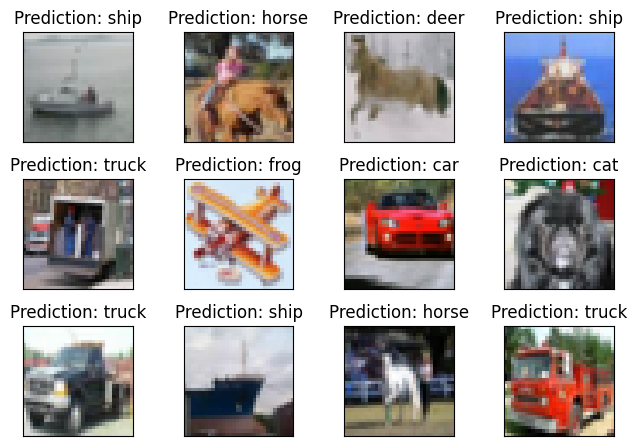

Test Loss: 115.339216, Test Acc: 59.520000


In [7]:
# 测试模型在一个或数个batch的分类情况，并输出图像及对应预测名称，打印正确率
print('start testing')
#加载模型
model_test = torch.load('./model/model_basic.ckpt')
#设置模型为评估模式
model_test.eval()
#设置测试集
mytest = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor())
mytest_loader = torch.utils.data.DataLoader(mytest, batch_size=50, shuffle=True)
#归一化
test_transform = transforms.Compose([
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # transforms.ToPILImage()
])
eval_loss = 0
eval_acc = 0
fig = plt.figure()
#batch 循环
for i,(img,label) in enumerate(mytest_loader):
    img,label = img.to(device),label.to(device)
    test_img = img
    img = test_transform(img)
    out = model_test(img)
    loss = criterion(out,label)
    #记录误差
    eval_loss += loss.data.item()*label.size(0)
    #计算准确率
    _,pred = torch.max(out,1)
    num_correct = (pred == label).sum().item()
    eval_acc += num_correct

    #绘制图片（归一化后）
    if i == 0:
        for j in range(12):
            plt.subplot(3,4,j+1)
            plt.tight_layout()
            plt.imshow(test_img[j].permute(1,2,0), interpolation='none')
            plt.title('Prediction: {}'.format(classes[pred[j].item()]))
            plt.xticks([])
            plt.yticks([])
plt.show()
print('Test Loss: {:.6f}, Test Acc: {:.6f}'.format(eval_loss/len(test_loader), eval_acc/len(test_loader)))